In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


In [8]:
def plot_image_histogram_rgb(image, nbins=64):
    # Check if the image is grayscale or RGB
    if len(image.shape) == 2:  # Grayscale image
        # Grayscale histogram
        plt.figure(figsize=(12, 3))
        plt.hist(image.ravel(), bins=nbins, color='gray', edgecolor='black', linewidth=0.5, alpha=0.6, label='Grayscale Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title('Grayscale Histogram')
        plt.xlim([0, 255])
        plt.legend()
        plt.tight_layout()
        plt.show()

    elif len(image.shape) == 3 and image.shape[2] == 3:  # RGB image
        # Separate the channels
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]

        # Plot histograms for each channel
        plt.figure(figsize=(12, 3))

        # Red channel histogram
        plt.hist(red_channel.ravel(), bins=nbins, range=(0, 255), color='red', edgecolor='black', linewidth=0.5, alpha=0.6, label='Red Channel Histogram')

        # Green channel histogram
        plt.hist(green_channel.ravel(), bins=nbins, range=(0, 255), color='green', edgecolor='black', linewidth=0.5, alpha=0.6, label='Green Channel Histogram')

        # Blue channel histogram
        plt.hist(blue_channel.ravel(), bins=nbins, range=(0, 255), color='blue', edgecolor='black', linewidth=0.5, alpha=0.6, label='Blue Channel Histogram')

        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title('Color Channel Histograms')
        plt.xlim([0, 255])
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Unsupported image format")


In [9]:
def plot_image_histogram_hue(image, nbins=64):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Separate the channels
    hue_channel = hsv_image[:, :, 0]

    # Plot histograms for each channel
    plt.figure(figsize=(12, 3))

    # Hue channel histogram with corresponding color
    hue_hist, bins = np.histogram(hue_channel.ravel(), bins=nbins, range=[0, 180])
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Normalize the bin centers to map them to [0, 1] for colors
    norm_bin_centers = bin_centers / 180

    # Create a color map based on the HSV values
    colors = plt.cm.hsv(norm_bin_centers)

    for i in range(nbins):
        plt.bar(bin_centers[i]*2, hue_hist[i], color=colors[i], width=((bins[1] - bins[0])* 2), edgecolor='black', alpha=0.6)

    plt.title('Hue Channel Histogram with Corresponding Colors')
    plt.xlabel('Hue Value (Degree)')
    plt.ylabel('Frequency')
    plt.xlim([0, 360])

    plt.tight_layout()
    plt.show()

In [10]:
def plot_image_histogram_saturation(image, nbins=64):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract the saturation channel
    saturation_channel = hsv_image[:, :, 1]

    plt.figure(figsize=(12, 3))

    # Saturation channel histogram (black to white gradient)
    saturation_hist, bins = np.histogram(saturation_channel.ravel(), bins=nbins, range=[0, 255])
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create a color map from blue to white for value
    colors_saturation = plt.cm.Blues(bin_centers / 255)

    for i in range(nbins):
        plt.bar(bin_centers[i], saturation_hist[i], color=colors_saturation[i], width=(bins[1] - bins[0]), edgecolor='black', alpha=0.6)

    plt.title('Saturation Channel Histogram (Blue to White Gradient)')
    plt.xlabel('Saturation')
    plt.ylabel('Frequency')
    plt.xlim([0, 255])

    plt.tight_layout()
    plt.show()

In [11]:
def plot_image_histogram_value(image, nbins=64):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract the value channel
    value_channel = hsv_image[:, :, 2]

    plt.figure(figsize=(12, 3))

    # Value channel histogram (black to white gradient)
    value_hist, bins = np.histogram(value_channel.ravel(), bins=nbins, range=[0, 255])
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create a color map from black to white for value
    colors_value = plt.cm.Greys(bin_centers / 255)

    for i in range(nbins):
        plt.bar(bin_centers[i], value_hist[i], color=colors_value[i], width=(bins[1] - bins[0]), edgecolor='black', alpha=0.6)

    plt.title('Value Channel Histogram (Black to White Gradient)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xlim([0, 255])

    plt.tight_layout()
    plt.show()

In [12]:
def float2uint8(image_float, is_hsv=False):
    """
    Convert an image from float [0.0, 1.0] to uint8 [0, 255] (for RGB) or [0, 180] (for H channel in HSV)

    Parameters:
    image_float (numpy array): Input image in float format
    is_hsv (Boolean): If the image is in HSV format, scale H channel differently

    Returns:
    numpy array: Image converted to uint8 format
    """
    if is_hsv:
        # H channel is scaled back to its original range of [0, 180]
        h_uint8 = np.clip(image_float[:, :, 0] * 180, 0, 180).astype(np.uint8)
        # S and V channels are scaled back to [0, 255]
        s_uint8 = np.clip(image_float[:, :, 1] * 255, 0, 255).astype(np.uint8)
        v_uint8 = np.clip(image_float[:, :, 2] * 255, 0, 255).astype(np.uint8)
        # Stack the H, S, and V channels back into a single array
        return np.stack((h_uint8, s_uint8, v_uint8), axis=2)
    else:
        # For RGB images, scale all channels uniformly
        return np.clip(image_float * 255, 0, 255).astype(np.uint8)


In [7]:
def uint82float(image_uint8, is_hsv=False):
    """
    Convert an image from uint8 [0, 255] to float [0.0, 1.0]

    Parameters:
    image_uint8 (numpy array): Input image in uint8 format
    is_hsv (Boolean): If the image is in HSV format, scale H differently (0-180 for H, 0-255 for S and V)

    Returns:
    numpy array: Image converted to float format
    """
    if is_hsv:
        # H channel is scaled to [0, 1] from its range of [0, 180]
        h_float = image_uint8[:, :, 0].astype(np.float32) / 180.0
        # S and V channels are scaled to [0, 1] from their range of [0, 255]
        s_float = image_uint8[:, :, 1].astype(np.float32) / 255.0
        v_float = image_uint8[:, :, 2].astype(np.float32) / 255.0
        # Stack the H, S, and V channels back into a single array
        return np.stack((h_float, s_float, v_float), axis=2)
    else:
        # For RGB images, scale all channels uniformly
        return image_uint8.astype(np.float32) / 255.0

def float2uint8(image_float, is_hsv=False):
    """
    Convert an image from float [0.0, 1.0] to uint8 [0, 255] (for RGB) or [0, 180] (for H channel in HSV)

    Parameters:
    image_float (numpy array): Input image in float format
    is_hsv (Boolean): If the image is in HSV format, scale H channel differently

    Returns:
    numpy array: Image converted to uint8 format
    """
    if is_hsv:
        # H channel is scaled back to its original range of [0, 180]
        h_uint8 = np.clip(image_float[:, :, 0] * 180, 0, 180).astype(np.uint8)
        # S and V channels are scaled back to [0, 255]
        s_uint8 = np.clip(image_float[:, :, 1] * 255, 0, 255).astype(np.uint8)
        v_uint8 = np.clip(image_float[:, :, 2] * 255, 0, 255).astype(np.uint8)
        # Stack the H, S, and V channels back into a single array
        return np.stack((h_uint8, s_uint8, v_uint8), axis=2)
    else:
        # For RGB images, scale all channels uniformly
        return np.clip(image_float * 255, 0, 255).astype(np.uint8)

In [2]:
!wget https://raw.githubusercontent.com/yyhtbs-yye/data4wget/main/images/image_proc_lenna.png
# Load image from URL
image = Image.open("image_proc_lenna.png")
image = np.array(image)

--2024-10-08 15:08:18--  https://raw.githubusercontent.com/yyhtbs-yye/data4wget/main/images/image_proc_lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘image_proc_lenna.png’

image_proc_lenna.pn 100%[===================>] 462.73K  --.-KB/s    in 0.07s   

2024-10-08 15:08:18 (6.39 MB/s) - ‘image_proc_lenna.png’ saved [473831/473831]



array([[226, 226, 223, ..., 230, 221, 200],
       [226, 226, 223, ..., 230, 221, 200],
       [226, 226, 223, ..., 230, 221, 200],
       ...,
       [ 84,  84,  92, ..., 173, 172, 177],
       [ 82,  82,  96, ..., 179, 181, 185],
       [ 82,  82,  96, ..., 179, 181, 185]], dtype=uint8)
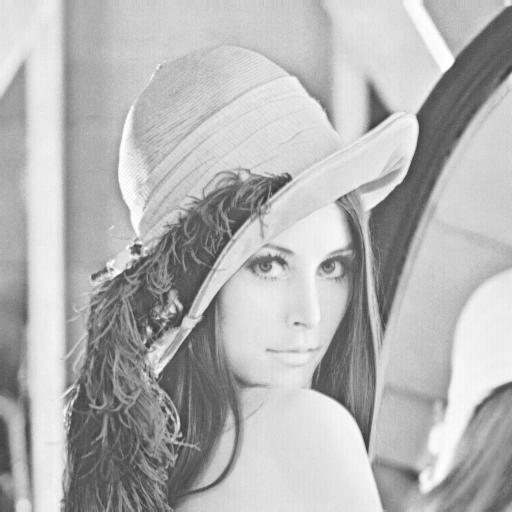

In [16]:
image[:, :, 0]

array([[137, 137, 137, ..., 148, 130,  99],
       [137, 137, 137, ..., 148, 130,  99],
       [137, 137, 137, ..., 148, 130,  99],
       ...,
       [ 18,  18,  27, ...,  73,  68,  62],
       [ 22,  22,  32, ...,  70,  71,  74],
       [ 22,  22,  32, ...,  70,  71,  74]], dtype=uint8)
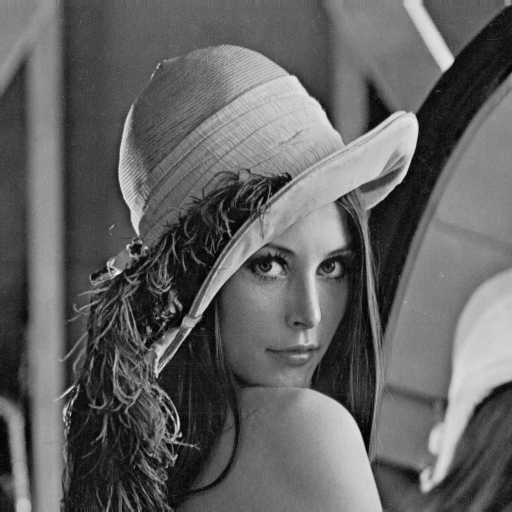

In [17]:
image[:, :, 1]

array([[125, 125, 133, ..., 122, 110,  90],
       [125, 125, 133, ..., 122, 110,  90],
       [125, 125, 133, ..., 122, 110,  90],
       ...,
       [ 60,  60,  58, ...,  84,  76,  79],
       [ 57,  57,  62, ...,  79,  81,  81],
       [ 57,  57,  62, ...,  79,  81,  81]], dtype=uint8)
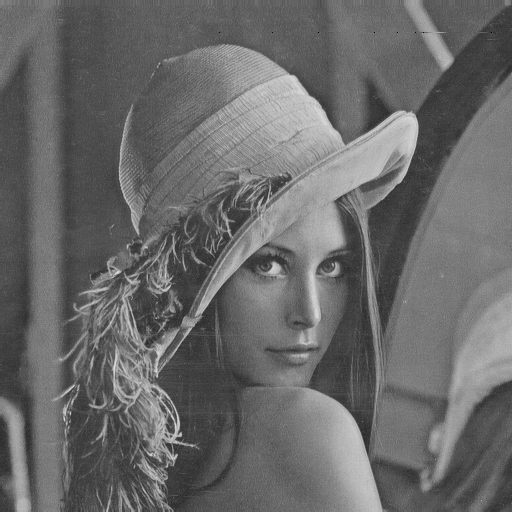

In [19]:
image[:, :, 2]

array([[  4,   4,   1, ...,   7,   5,   2],
       [  4,   4,   1, ...,   7,   5,   2],
       [  4,   4,   1, ...,   7,   5,   2],
       ...,
       [161, 161, 166, ..., 177, 178, 176],
       [163, 163, 166, ..., 178, 177, 178],
       [163, 163, 166, ..., 178, 177, 178]], dtype=uint8)
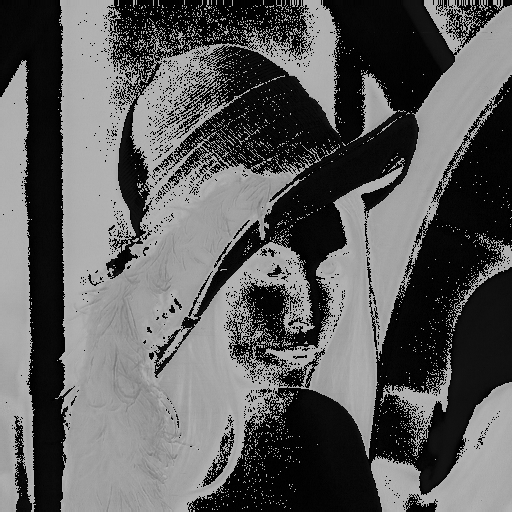

In [20]:
# Convert RGB to HSV
# hsv = hue, saturation, value
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

image_hsv[:, :, 0]

array([[114, 114, 103, ..., 120, 128, 140],
       [114, 114, 103, ..., 120, 128, 140],
       [114, 114, 103, ..., 120, 128, 140],
       ...,
       [200, 200, 180, ..., 147, 154, 166],
       [187, 187, 170, ..., 155, 155, 153],
       [187, 187, 170, ..., 155, 155, 153]], dtype=uint8)
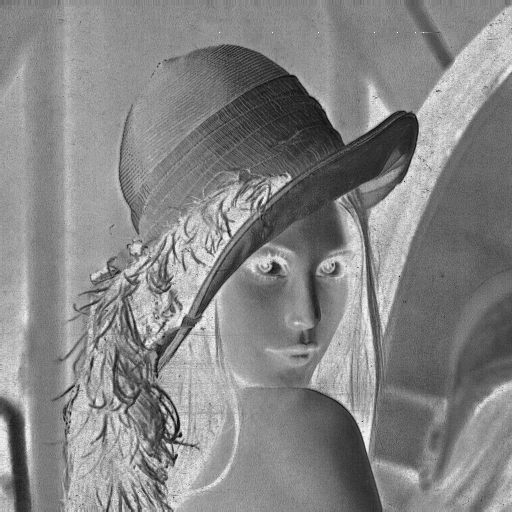

In [21]:
image_hsv[:, :, 1]

array([[226, 226, 223, ..., 230, 221, 200],
       [226, 226, 223, ..., 230, 221, 200],
       [226, 226, 223, ..., 230, 221, 200],
       ...,
       [ 84,  84,  92, ..., 173, 172, 177],
       [ 82,  82,  96, ..., 179, 181, 185],
       [ 82,  82,  96, ..., 179, 181, 185]], dtype=uint8)
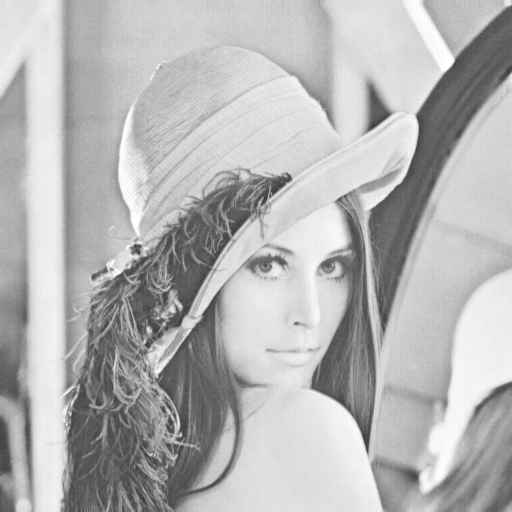

In [23]:
image_hsv[:, :, 2]

array([[[  4, 114, 226],
        [  4, 114, 226],
        [  1, 103, 223],
        ...,
        [  7, 120, 230],
        [  5, 128, 221],
        [  2, 140, 200]],

       [[  4, 114, 226],
        [  4, 114, 226],
        [  1, 103, 223],
        ...,
        [  7, 120, 230],
        [  5, 128, 221],
        [  2, 140, 200]],

       [[  4, 114, 226],
        [  4, 114, 226],
        [  1, 103, 223],
        ...,
        [  7, 120, 230],
        [  5, 128, 221],
        [  2, 140, 200]],

       ...,

       [[161, 200,  84],
        [161, 200,  84],
        [166, 180,  92],
        ...,
        [177, 147, 173],
        [178, 154, 172],
        [176, 166, 177]],

       [[163, 187,  82],
        [163, 187,  82],
        [166, 170,  96],
        ...,
        [178, 155, 179],
        [177, 155, 181],
        [178, 153, 185]],

       [[163, 187,  82],
        [163, 187,  82],
        [166, 170,  96],
        ...,
        [178, 155, 179],
        [177, 155, 181],
        [178, 153, 185]]], dtype=uint8)
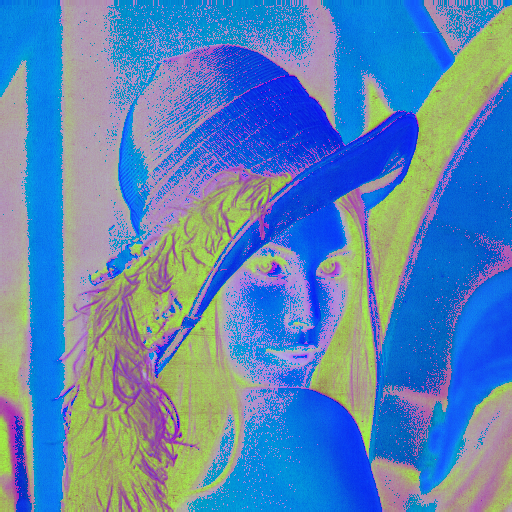

In [25]:
image_hsv[:, :, :]

In [28]:
#
# converts hue from int [0, 180] to float [0., 1.]
# converst saturation from uint [0, 256] to float [0., 1.]
image_hsv_float = uint82float(image_hsv, is_hsv=True)

print(type(image_hsv_float))


<class 'numpy.ndarray'>


In [55]:
hue_gamma = 2 # Adjust this gamma value for experimentation

# Copy the floating point image as an output initialization
image_hsv_corrected_float = image_hsv_float.copy()

# Apply gamma correction to hue only
image_hsv_corrected_float[:, :, 0] = (image_hsv_float[:, :, 0] ** hue_gamma)

image_hsv_corrected = float2uint8(image_hsv_corrected_float, is_hsv=True)

image_rgb_corrected = cv2.cvtColor(image_hsv_corrected, cv2.COLOR_HSV2RGB)

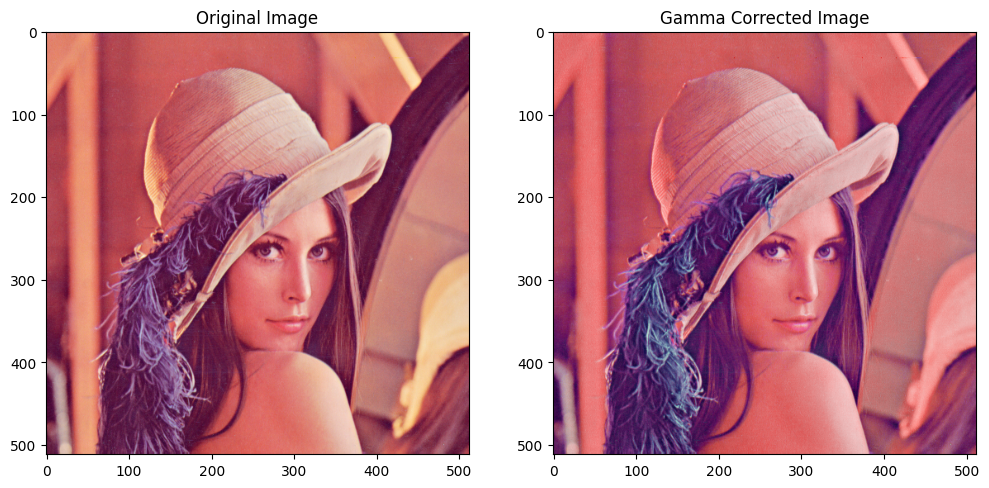

In [56]:
# Plot original and corrected images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)

# Corrected image
plt.subplot(1, 2, 2)
plt.title("Gamma Corrected Image")
plt.imshow(image_rgb_corrected)

plt.show()

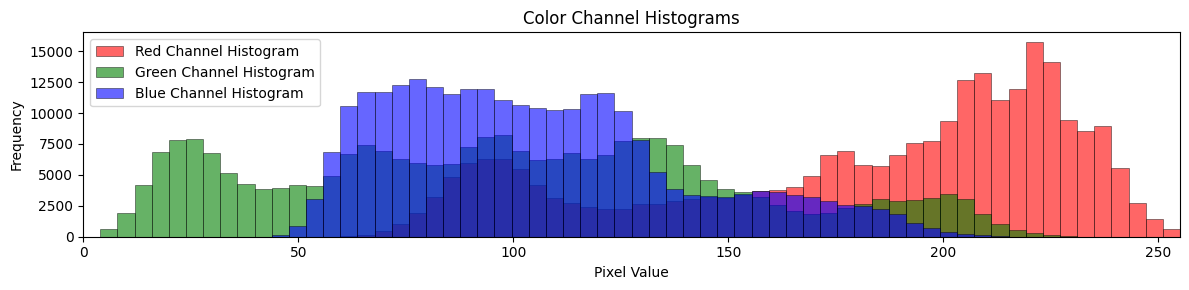

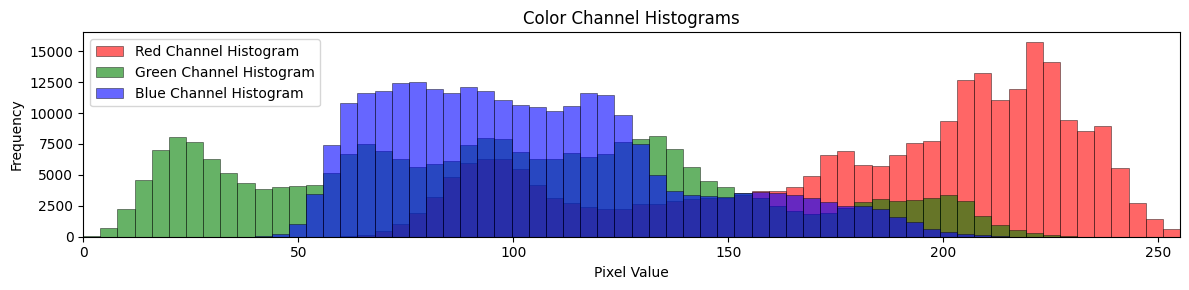

In [35]:
plot_image_histogram_rgb(image)
plot_image_histogram_rgb(image_rgb_corrected)

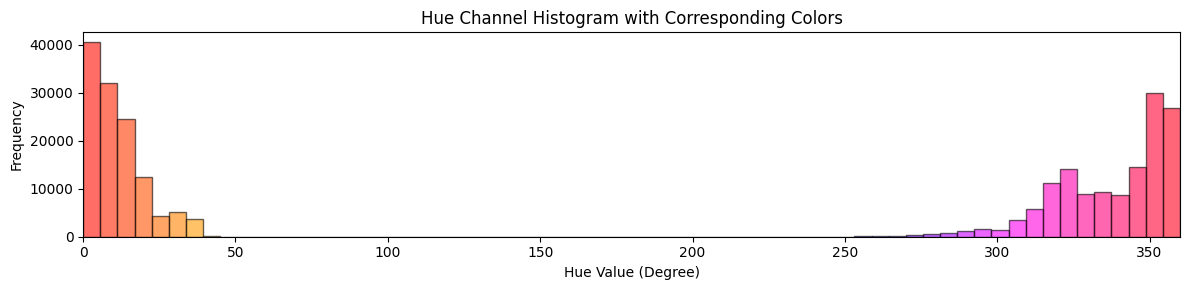

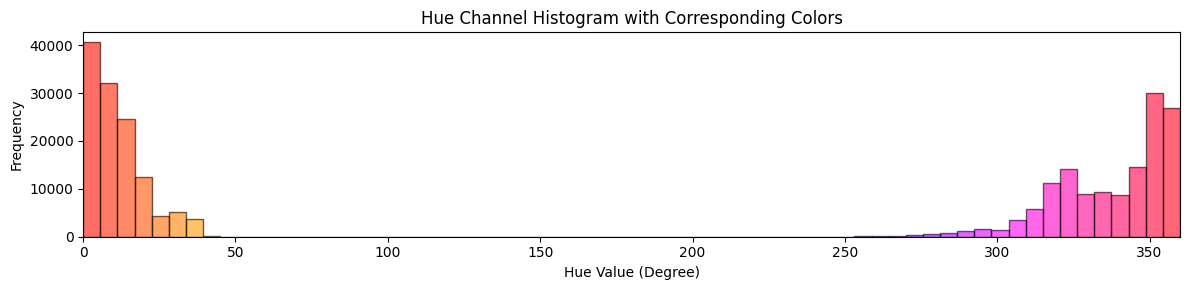

In [36]:
plot_image_histogram_hue(image)
plot_image_histogram_hue(image_rgb_corrected)

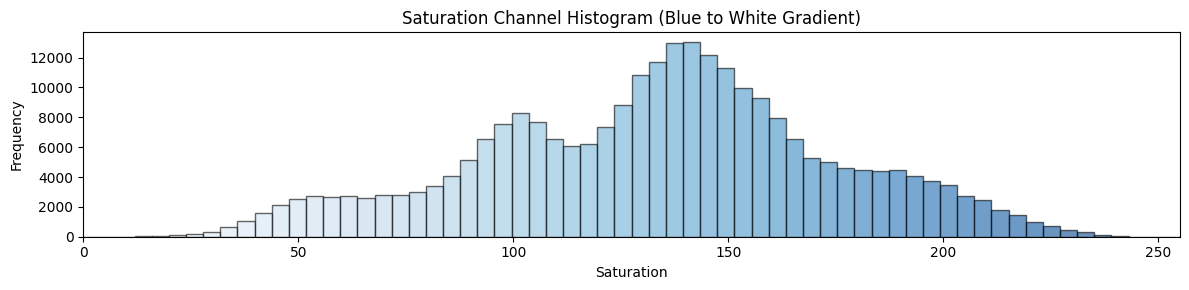

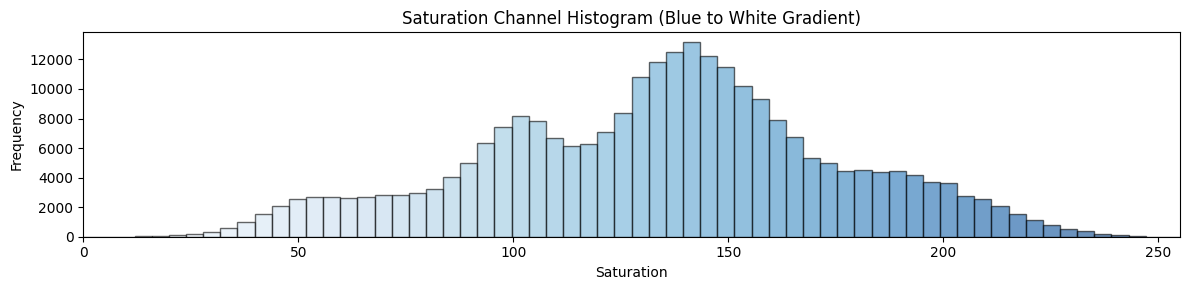

In [37]:
plot_image_histogram_saturation(image)
plot_image_histogram_saturation(image_rgb_corrected)

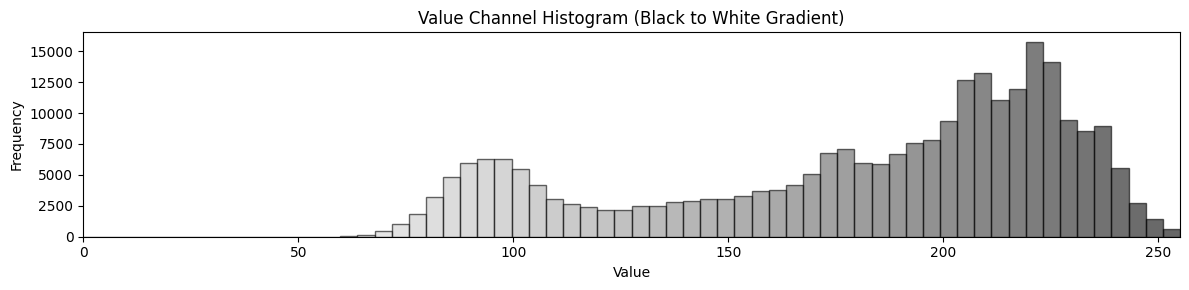

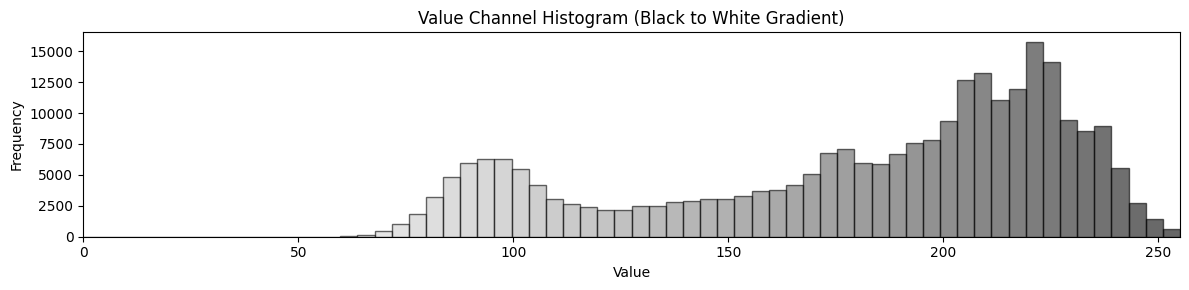

In [38]:
plot_image_histogram_value(image)
plot_image_histogram_value(image_rgb_corrected)